# The McCall Search Model

Contents:

- [The McCall Search Model](#The-McCall-Search-Model)  
  - [Revisiting the Finite-State McCall Model](#Revisiting-the-Finite-State-McCall-Model)  
  - [Solving for the Optimal Policy](#Solving-for-the-Optimal-Policy)
  - [Implementing Value Function Iteration](#Implementing-Value-Function-Iteration)  
  - [Comparative Statics](#Comparative-Statics)   


This lab includes:

(1) An overview of the finite-state McCall search model;

(2) A description of the value function iteration algorithm;

(3) An implementation of value function iteration applied to the McCall model;

(4) Some simple comparative statics analysis of the McCall model.

----

## Revisiting the Finite-State McCall Model

We start by briefly reviewing the finite-state McCall model setup.

A worker wants to maximize expected lifetime utility, $\mathbb{E} \sum_{t=0}^\infty \beta^t y_t$, where $\beta \in (0,1)$ is the discount factor and $\{y_t\}$ is an income sequence.

The worker starts out being unemployed, but at each period they receive a job offer with wage $w$ drawn from a finite i.i.d. distribution (known to the worker) with outcomes $\{w_1,\ldots,w_S\}$ and corresponding probability weights $\{p_1,\ldots,p_S\}$.

At time $T$ the worker may accept the given job offer and receive the wage $w$ for all $t \geq T$.

Or the worker may reject the offer, receive the unemployment check $c > 0$ at time $T$, and repeat the job search again at $T+1$.

The worker chooses whichever option is associated with a greater expected lifetime utility. Therefore, the value function $v(w)$ of this problem satisfies the Bellman equation 

\begin{align}
    v(w) = \max_{\text{accept,reject}} \left\{ \frac{w}{1-\beta} \, , \, c + \beta \sum_{i = 1}^S v(w_i ') p_i \right\} 
\end{align}

In this lab we will combine some of the tools we've learned in the first two labs to solve for the value function of the above Bellman equation.

---

##  Solving for the Optimal Policy

The Bellman equation is equivalent to the following nonlinear system of equations that we need to solve with respect to the $v_i$'s:

\begin{align}
v_i = \max \left\{ \frac{w_i}{1 - \beta} \, , \, c + \beta \sum_{i=1}^S v_i p_i \right\} \text{ for } i = 1,\ldots,S \, .
\end{align}

Our solution to this system of equations should be of the form $v \in \mathbb{R}^S$.

The value function iteration algorithm allows us to solve for $v$ with the following steps:

(1) Pick some $v \in \mathbb{R}^S$ -- the initial guess for the solution;

(2) Map the chosen $v$ using the Bellman mapping to obtain $v_1 \in \mathbb{R}^S$, so that 
\begin{align*} 
v_i' = \max \left\{ \frac{w_i}{1-\beta} \, , \, c + \beta \sum_{i=1}^S v_i p_i \right\} \text{ for } i = 1,\ldots,S \, ;
\end{align*} 

(3) Note the deviation between $v$ and $v'$ -- if the deviation is above some threshhold then stop, otherwise repeat the process.

Once the above process stops, the resulting $v$ will be an approvimation of the true solution for the value function.

Given $|\beta| < 1$, our Bellman map satisfies the assumptions of the Banach contraction mapping theorem, which implies that our generated sequence of values should converge to a unique fixed point.

---

## Implementing Value Function Iteration

First we load all necessary packages.

In [1]:
using LinearAlgebra

We create a function that carries out a single iteration of the Bellman mapping.

We can then repeatedly call on this function when applying the algorithm.

This function will be called `mccallbellmanmap`, and will take an initial value function `v`, a vector of possible wages `w`, a vector of probabilities associated with each of the wages `π`, the unemployment benefit `c`, and the discount factor `β`, as inputs.

`mccallbellmanmap()` will output a new mapping of `v`.


In [3]:
"""
    mccallbellmanmap(v,w,π,c,β)

Iterates the McCall search model bellman equation for with value function v.
Returns the new value function.

# Arguments
* `v` vector of values for each wage
* `w` vector of wages
* `p` vector of probabilities for each wage
* `c` unemployment benefits
* `β` time discount factor

"""

function mccallbellmanmap(v, w, p, c, β)
    
    # Create empty vector for value storage
    v_out = zeros(length(w))
    
    # Compute value given each wage in vector `w`
    for i in 1:length(w)
        
        # Bellman map: v = max{c + β E(v'), w/(1-β)}
        v_out[i] = max(c + β * dot(p,v), w[i]/(1-β)) 
        
    end
    
    # Return value function
    return v_out
end

mccallbellmanmap (generic function with 1 method)

We may also avoids loops entirely by defining an alternative function `mccallbellmanmap_v2` that takes the same exact inputs and gives the same output.

In [2]:
"""
    mccallbellmanmap_v2(v,w,π,c,β)

Iterates the McCall search model bellman equation for with value function v.
Returns the new value function.

# Arguments
* `v` vector of values for each wage
* `w` vector of wages
* `p` vector of probabilities for each wage
* `c` unemployment benefits
* `β` time discount factor

"""
function mccallbellmanmap_v2(v, w, p, c, β)
    
    # Compute value of rejecting the offer
    v_reject = c + β * dot(p,v) # this is a Float
    
    # Compute value of accepting the wage offer
    v_accept = w / (1-β)
    
    # Compute v_reject to v_accept
    v_out = max.(v_reject, v_accept)
    
    # Return value function
    return v_out
end

mccallbellmanmap_v2

Now let's iterate over the Bellman map to see what it does.

In [4]:
# Create discrete uniform wage distribution between 1 and 10
# where S = # of grid points (evenly-spaced points between 1 and 10)
S = 10
w = LinRange(1, 10, S) 
p = ones(S)/S # each p[i] = 1/S ∀i, so that p(w[i]) = p(w[j]) ∀i,j ∈ {1,...,S}

# Set model parameters:
β = 0.95 # note that lower β causes code to converge faster
c = 3 # unemployment wage/benefits

# Initiate the value function
v0 = zeros(S)

# Iterate code J times
J = 50

# Create and initiate array containing 
# iterated value function values:
V = zeros(J, S)
V[1,:] = mccallbellmanmap(v0, w, p, c, β)

# Keep applying Bellman map recursively 
for j in 2:J
    V[j,:] = mccallbellmanmap_v2(V[j-1,:], w, p, c, β)
end

V

50×10 Matrix{Float64}:
  20.0     40.0     60.0     80.0    …  140.0    160.0    180.0  200.0
 107.5    107.5    107.5    107.5       140.0    160.0    180.0  200.0
 130.062  130.062  130.062  130.062     140.0    160.0    180.0  200.0
 141.736  141.736  141.736  141.736     141.736  160.0    180.0  200.0
 148.554  148.554  148.554  148.554     148.554  160.0    180.0  200.0
 153.089  153.089  153.089  153.089  …  153.089  160.0    180.0  200.0
 156.104  156.104  156.104  156.104     156.104  160.0    180.0  200.0
 158.109  158.109  158.109  158.109     158.109  160.0    180.0  200.0
 159.443  159.443  159.443  159.443     159.443  160.0    180.0  200.0
 160.329  160.329  160.329  160.329     160.329  160.329  180.0  200.0
   ⋮                                 ⋱                           
 162.916  162.916  162.916  162.916     162.916  162.916  180.0  200.0
 162.916  162.916  162.916  162.916     162.916  162.916  180.0  200.0
 162.916  162.916  162.916  162.916     162.916  162.916  1

Let's plot the columns of `V`:

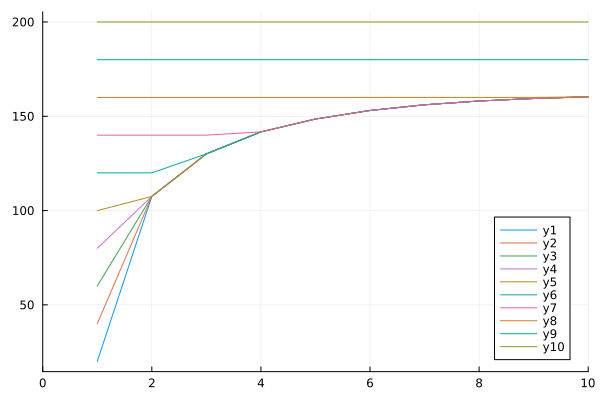

In [5]:
using Plots

plot(V, xlim = (0,10))

We can define a neat function that solves any given finite-state McCall model.

In [7]:
"""
    solvemccall(w,π,c,β[,ϵ])

Iterates the McCall search model bellman equation until convergence criterion 
ϵ is reached

# Arguments
* `w` vector of wages
* `p` vector of probabilities for each wage
* `c` unemployment benefits
* `β` time discount factor
* `ϵ' Stopping criteria (default 1e-6)
"""

function solvemccall(w, p, c, β, ϵ=1e-6)
    
    # Initialize the value function.
    v = w/(1-β)
    
    # Initiate distance from iterated mapping
    diff = 10
    
    # Keep iterating on Bellman map until
    # stopping criterium is satisfied
    while diff > ϵ
        
        # New mapping of the value function
        v_new = mccallbellmanmap(v,w,p,c,β)
        
        # Use supremum norm as measure of distance between 
        # old vs. new value function map
        diff = norm(v-v_new,Inf)
        
        # Store new value function as original
        # before loop potentially restarts
        v = v_new 
    end
    
    # Return converged value function
    return v
end

solvemccall (generic function with 2 methods)

We can use our function to solve the McCall model defined by the previously-declared parameters (which I repeat here for ease of reference). 

In [8]:
S = 10
w = LinRange(1, 10, S) 
p = ones(S)/S 
β = 0.95 
c = 3

# Solve the model:
v = solvemccall(w,p,c,β)

10-element Vector{Float64}:
 162.91666382521822
 162.91666382521822
 162.91666382521822
 162.91666382521822
 162.91666382521822
 162.91666382521822
 162.91666382521822
 162.91666382521822
 179.99999999999983
 199.99999999999983

---

## Comparative Statics

Let's vary $\beta$ while keeping all else constant, and check what happens to $V(w)$:

   Resolving package versions...
    Updating `C:\Users\leide\.julia\environments\v1.11\Project.toml`
  [b964fa9f] + LaTeXStrings v1.4.0
  No Changes to `C:\Users\leide\.julia\environments\v1.11\Manifest.toml`


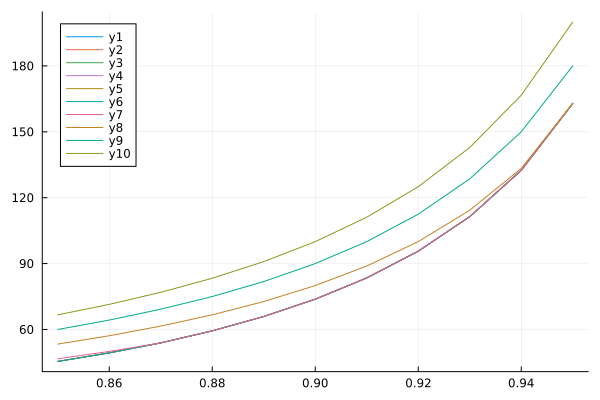

In [ ]:

using Pkg
Pkg.add("LaTeXStrings")


using Plots, LaTeXStrings

S = 10
w = LinRange(1, 10, S) 
p = ones(S)/S 
β = 0.95 
c = 3

g(θ) = solvemccall(w,p,c,θ)

fig = plot(); # Limit the plot y-axis
    
for i in 1:length(w)
    plot!(fig, 0.85:0.01:0.95, θ -> g(θ)[i])
end 

fig

What if we, instead, vary $c$?

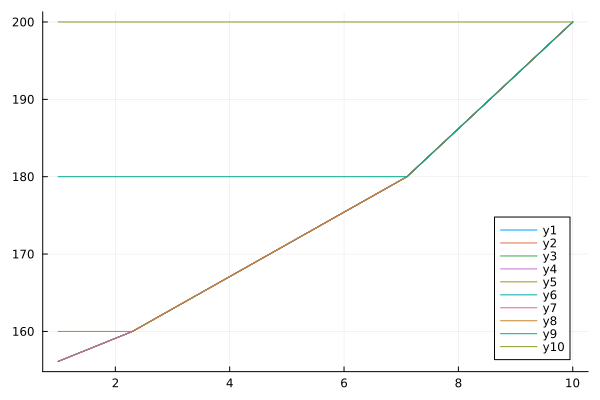

In [13]:
using Plots, LaTeXStrings

S = 10
w = LinRange(1, 10, S) 
p = ones(S)/S 
β = 0.95 
c = 3

g(θ) = solvemccall(w,p,θ,β)

fig = plot(); # Limit the plot y-axis
    
for i in 1:length(w)
    plot!(fig, 1:0.01:10, θ -> g(θ)[i])
end 

fig

----